In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "hypo.10.02.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
620,SMC,4.667707e-08,1.944797e-08,0.008195,Deary.MolPsychiatry.2017.Tiredness_,2.086435
621,ACx_MEIS2_GABA,4.225042e-08,2.223328e-08,0.028695,Deary.MolPsychiatry.2017.Tiredness_,1.542189
622,F_Glut,3.626610e-08,2.082271e-08,0.040784,Deary.MolPsychiatry.2017.Tiredness_,1.389512
623,Pericyte,2.018289e-08,1.208574e-08,0.047462,Deary.MolPsychiatry.2017.Tiredness_,1.323653
624,Endo,1.363903e-08,8.552620e-09,0.055387,Deary.MolPsychiatry.2017.Tiredness_,1.256589


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

2356    0.004515
2728    0.004515
1209    0.004933
2357    0.013726
1210    0.018085
          ...   
1301    0.996647
3564    0.996647
681     0.996647
2757    0.996647
1177    0.996647
Name: FDR_BH_corrected, Length: 589, dtype: float64


In [10]:
print(adj_pval.sort_values())

2356    0.004515
1209    0.004933
2728    0.008312
2357    0.013726
1210    0.018085
          ...   
1294    1.004702
2817    1.005147
646     1.005303
3560    1.006273
3563    1.006297
Name: adj_pval, Length: 589, dtype: float64


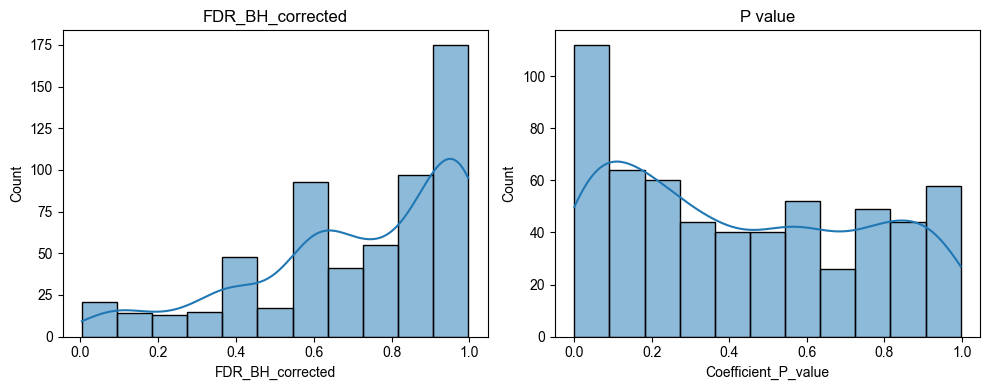

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.430369,0.258154,0.079017,1.542189,0.075209,0.117802,0.179400,0.325911,0.233166,0.287495,1.076790,0.637025,0.127605,0.404683,0.515580,0.603655,0.454831,0.516270,0.045613
Astrocyte,0.344063,0.087691,0.280762,0.062879,1.202344,0.856515,0.357920,0.086807,1.232115,1.280072,0.425297,0.036705,1.070164,0.520738,0.062455,1.376340,0.900890,0.820816,0.216594
CN_Cholinergic_GABA,0.631342,0.028808,0.592382,0.543331,0.660730,0.042357,0.017374,0.192577,0.526588,0.938264,0.191782,0.278482,0.293717,0.426336,0.389656,0.567663,0.113114,0.784283,0.031901
CN_GABA-Glut,1.339305,0.745187,0.038992,0.147396,0.149918,1.476917,0.038524,0.114871,0.729035,0.375027,1.051490,0.174757,0.511021,0.107858,0.200507,1.500242,0.288800,0.418619,0.058514
CN_LAMP5-CXCL14_GABA,0.216848,0.459901,0.006660,0.014446,0.023896,0.038551,0.067620,0.325980,0.194044,1.518110,0.137543,0.424577,0.477585,0.471614,0.543243,0.883356,0.189270,0.856349,0.328882


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.754507,0.887662,0.991957,0.318057,0.994952,0.969781,0.923427,0.850466,0.893447,0.873054,0.451469,0.631374,0.969781,0.770664,0.707459,0.650090,0.751540,0.707459,0.994952
Astrocyte,0.833494,0.984264,0.876210,0.994952,0.401775,0.569707,0.814959,0.984264,0.385906,0.385906,0.754507,0.994952,0.451469,0.707459,0.994952,0.367410,0.557980,0.585572,0.893447
CN_Cholinergic_GABA,0.632715,0.996626,0.650090,0.701299,0.631089,0.994952,0.996626,0.908233,0.706441,0.537600,0.908233,0.876210,0.865611,0.754507,0.782802,0.677812,0.969781,0.603422,0.996626
CN_GABA-Glut,0.374522,0.603422,0.994952,0.965424,0.963185,0.326930,0.994952,0.969781,0.607379,0.796038,0.467097,0.928950,0.709339,0.969781,0.902664,0.321882,0.872943,0.758934,0.994952
CN_LAMP5-CXCL14_GABA,0.893447,0.747590,0.996626,0.996626,0.996626,0.994952,0.994952,0.850466,0.907868,0.319020,0.969781,0.754507,0.739817,0.740181,0.701299,0.562391,0.910660,0.569707,0.849865


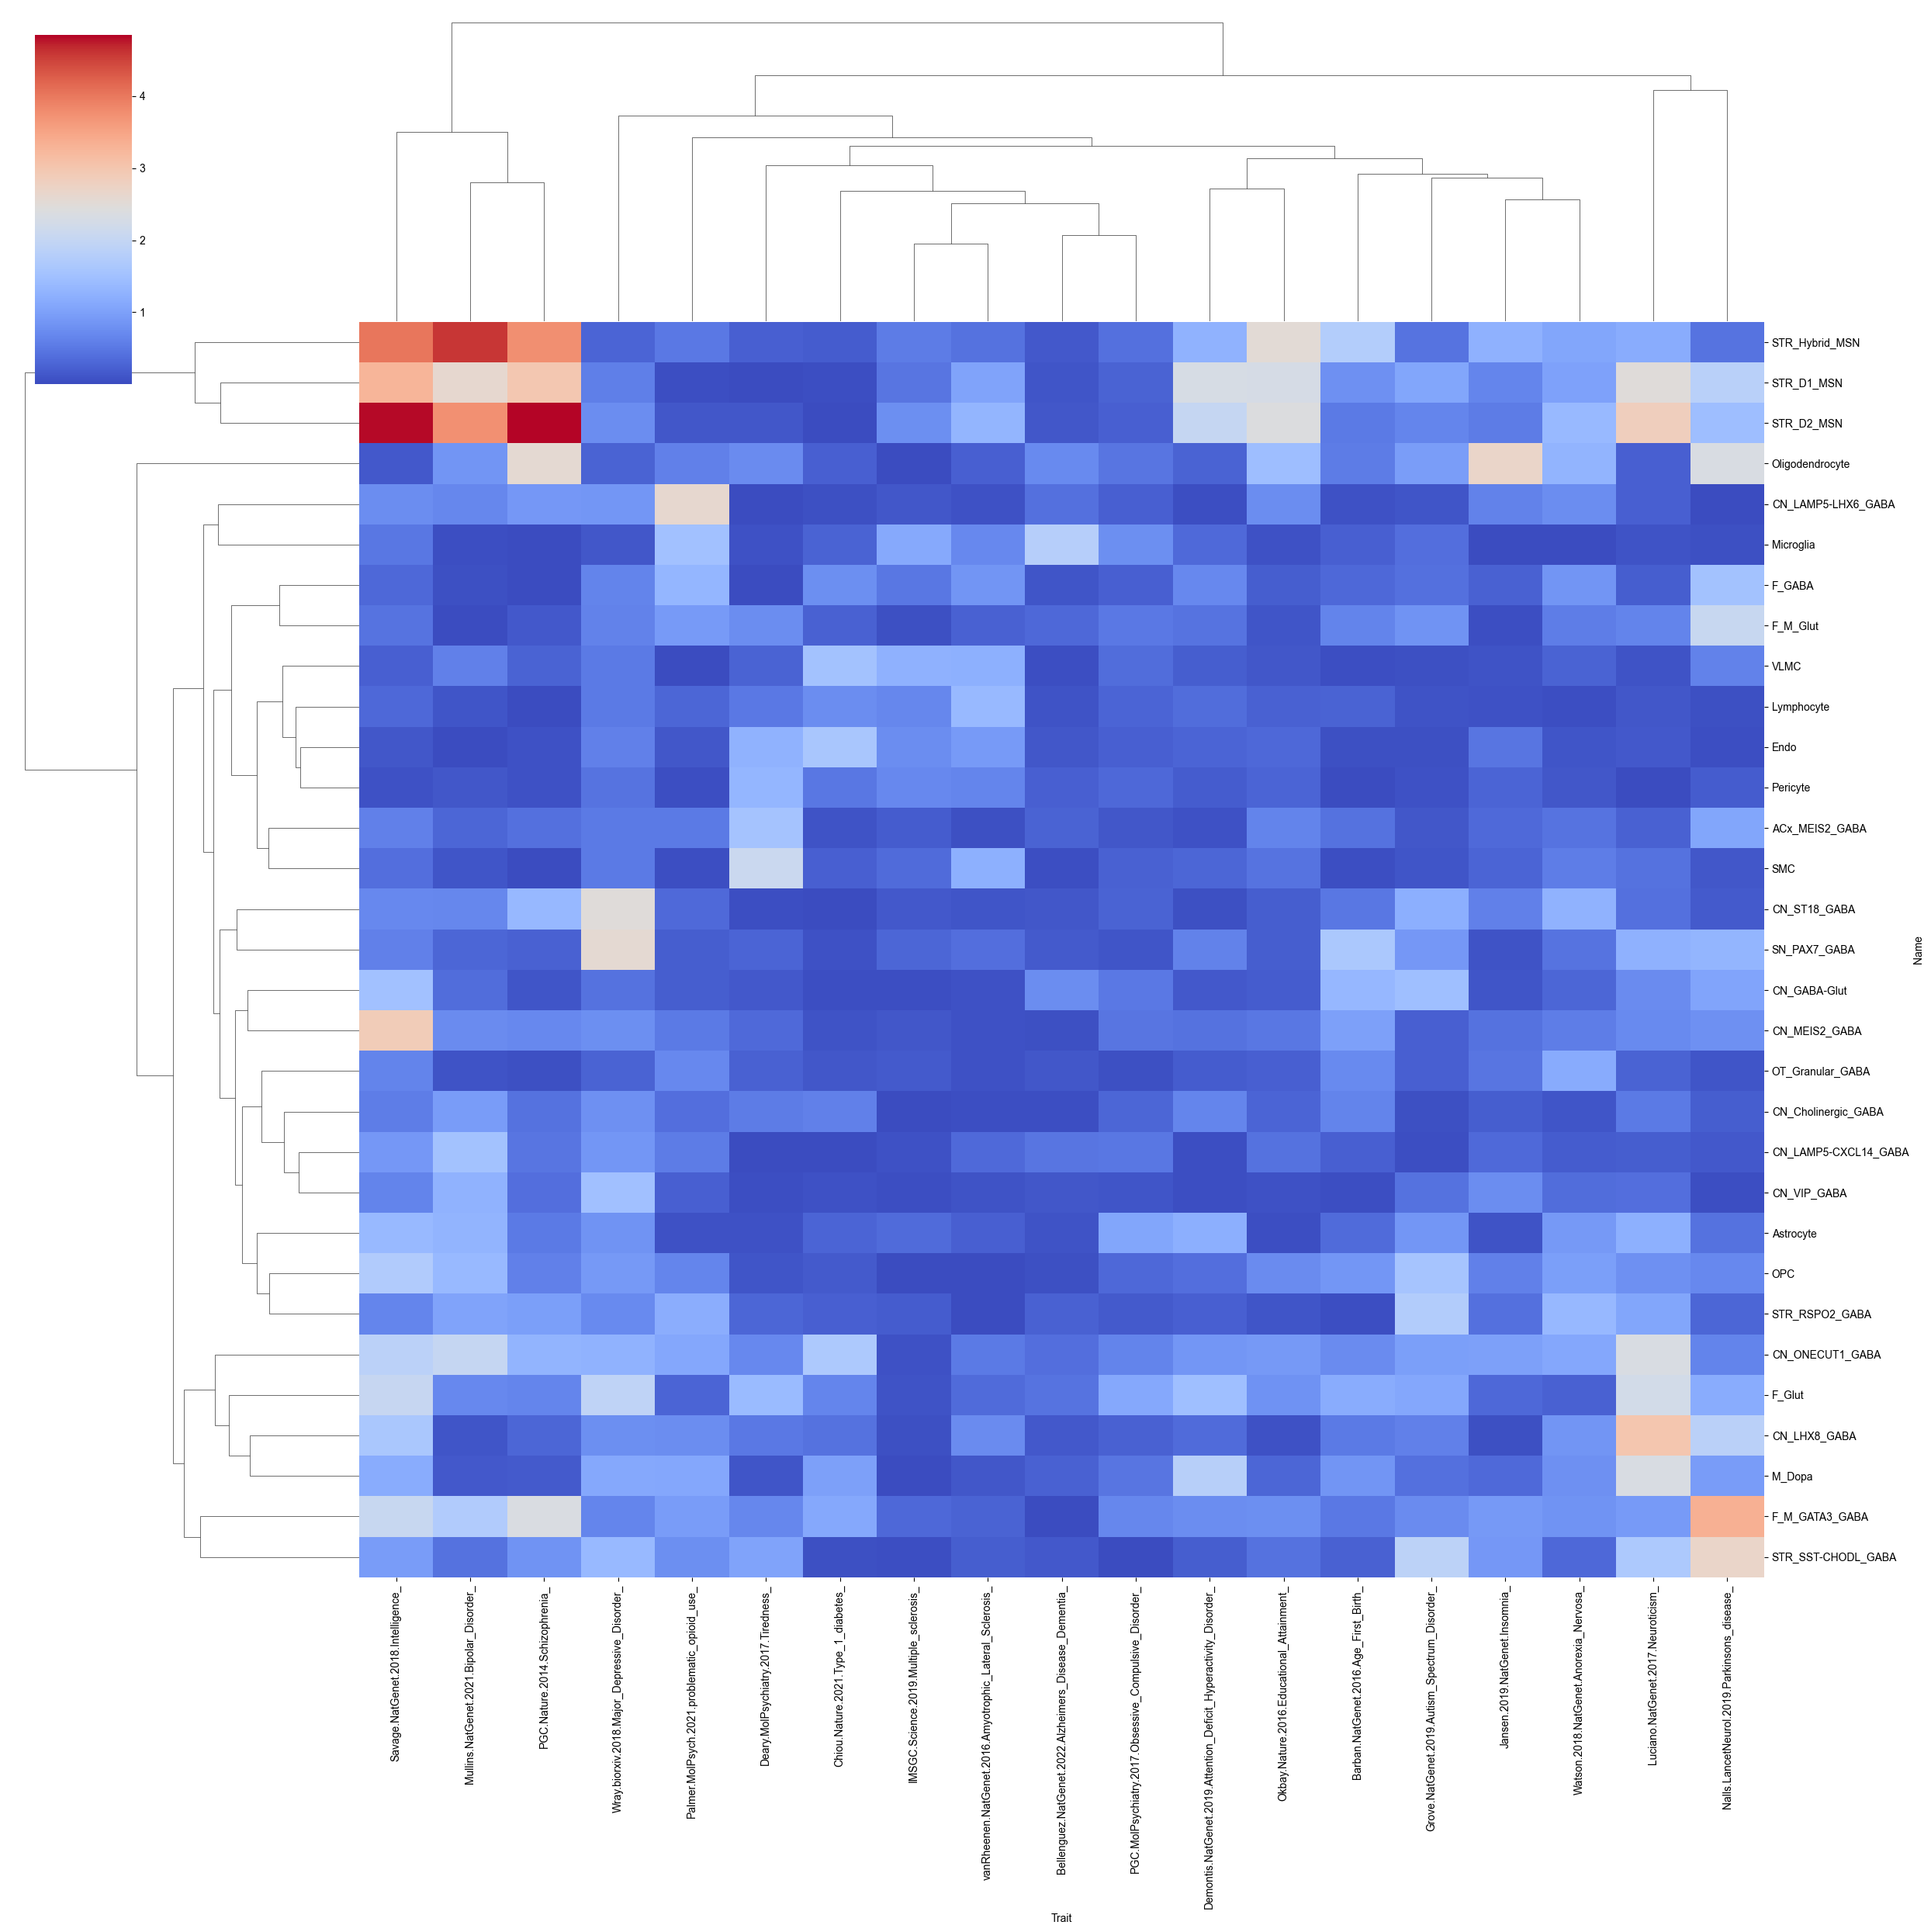

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [28]:
def pval_to_star(p):
    if p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Intelligence', 'Bipolar Disorder', 'Schizophrenia',
       'Parkinson's Disease'],
      dtype='object', name='Trait')

In [20]:
np.log10(0.05)

-1.3010299956639813

In [22]:
import os,sys
metadata = pd.read_csv(os.path.expanduser("~/Projects/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron
Microglia,Immune,Nonneuron
OPC,OPC-Oligo,Nonneuron
Oligodendrocyte,OPC-Oligo,Nonneuron
Endo,Vascular,Nonneuron


In [23]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

['F Glut', 'F M Glut', 'M Dopa', 'Astrocyte', 'Lymphocyte', 'Microglia', 'OPC', 'Oligodendrocyte', 'Endo', 'Pericyte', 'SMC', 'VLMC', 'CN LAMP5-CXCL14 GABA', 'CN VIP GABA', 'CN MEIS2 GABA', 'OT Granular GABA', 'STR D1 MSN', 'STR D2 MSN', 'STR Hybrid MSN', 'CN Cholinergic GABA', 'CN LAMP5-LHX6 GABA', 'CN ST18 GABA', 'STR RSPO2 GABA', 'STR SST-CHODL GABA', 'ACx MEIS2 GABA', 'CN LHX8 GABA', 'CN ONECUT1 GABA', 'F GABA', 'F M GATA3 GABA', 'SN PAX7 GABA', 'CN GABA-Glut']
4.850397343564654


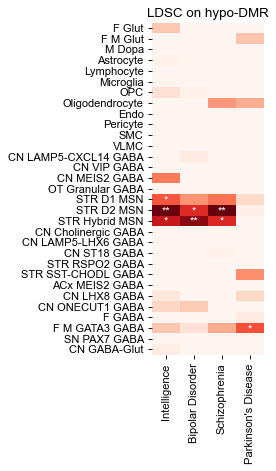

In [29]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
print(row_order)
vmax=modified_df.loc[: ,cols_to_keep].max().max()
print(vmax)
plt.figure(figsize=(3.5, 6))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='Reds',cbar_kws={'shrink': 0.4,'fraction':0.15,'aspect':6},
               # annot_kws=dict(color='white',fontweight='bold'),
               vmin=1.3,cbar=False,vmax=4.85,
              )
# plt.title("-log10(pval) with FDR corrected p value stars")
plt.title("LDSC on hypo-DMR")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
# cbar = ax.collections[0].colorbar
# cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
# cbar.set_ticks([1.3,3,4,4.85])
plt.tight_layout()
# plt.savefig(f'{run_id}_filtered_FDR.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/hypo_dmr.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()